# IIC-3641 GML UC

In [1]:
import sys, platform, subprocess
print("Python:", platform.python_version())      # p.ej., 3.11.9
print("Version info:", sys.version_info)         # tuple detallada
print("Executable:", sys.executable)             # ruta del intérprete
subprocess.run([sys.executable, "-m", "pip", "--version"])  # pip correspondiente

Python: 3.10.12
Version info: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Executable: /usr/bin/python3
pip 25.2 from /home/marcelo/.local/lib/python3.10/site-packages/pip (python 3.10)


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', '--version'], returncode=0)

In [2]:
import torch
#print(torch.__version__)
import importlib.metadata

info = importlib.metadata.metadata("torch")

print("Nombre:", info["Name"])
print("Versión:", info["Version"])
print("Email autor:", info["Author-email"])
print("Licencia:", info["License"])
print("Resumen:", info["Summary"])

Nombre: torch
Versión: 2.4.1+cu118
Email autor: packages@pytorch.org
Licencia: BSD-3
Resumen: Tensors and Dynamic neural networks in Python with strong GPU acceleration


In [3]:
import torch_geometric
import torch_scatter, torch_sparse, torch_cluster, torch_spline_conv

print("torch-geometric:", torch_geometric.__version__)
print("torch-scatter:", torch_scatter.__version__)
print("torch-sparse:", torch_sparse.__version__)
print("torch-cluster:", torch_cluster.__version__)
print("torch-spline-conv:", torch_spline_conv.__version__)


torch-geometric: 2.6.1
torch-scatter: 2.1.2+pt24cu118
torch-sparse: 0.6.18+pt24cu118
torch-cluster: 1.6.3+pt24cu118
torch-spline-conv: 1.2.2+pt24cu118


## Primero usaremos pooling sobre GCNs

In [4]:
# DiffPool vs MinCutPool en Cora (PyTorch Geometric)
# -------------------------------------------------
# Este script entrena dos modelos de pooling jerárquico (DiffPool y MinCutPool)
# sobre el grafo único de Cora para:
# 1) Obtener asignaciones de nodos->clusters (matriz S)
# 2) Realizar clasificación de nodos (supervisión estándar de Cora)
# 3) Evaluar calidad de clustering con ARI/NMI a partir de S (hard argmax)
#
# Nota: Cora es un solo grafo grande; entrenamos con B=1 en las variantes densas
# de DiffPool/MinCut. El objetivo principal es node classification (semi-supervisado)
# + regularizadores propios de cada método. Además, medimos ARI/NMI como métrica
# de calidad de clusters frente a etiquetas de clase.

import os
import math
import random
import numpy as np
from dataclasses import dataclass

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv

# Funciones de pooling densas
from torch_geometric.nn.dense.diff_pool import dense_diff_pool
from torch_geometric.nn.dense.mincut_pool import dense_mincut_pool

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# -------------------------------------------------
# Utilidades
# -------------------------------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def hard_assign(S: torch.Tensor) -> torch.Tensor:
    """Devuelve asignación dura por argmax a partir de S (B, N, K) -> (N,)"""
    # S es (B, N, K), con B=1
    return S[0].argmax(dim=-1).detach().cpu()


# -------------------------------------------------
# Cargador de datos (Cora)
# -------------------------------------------------

def load_cora(device):
    dataset = Planetoid(root=os.path.join('data', 'Cora'), name='Cora')
    data = dataset[0]
    data = data.to(device)
    # Construimos adj densas (B=1)
    A = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes)
    A = A.to(device)  # (1, N, N)
    X = data.x.unsqueeze(0).to(device)  # (1, N, F)
    y = data.y.to(device)  # (N,)
    return data, X, A, y, dataset.num_features, dataset.num_classes


# -------------------------------------------------
# Bloques GNN para producir S y Z (embeddings de nodos)
# -------------------------------------------------

class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.5):
        super().__init__()
        self.g1 = GCNConv(in_ch, hid_ch)
        self.g2 = GCNConv(hid_ch, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.g1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.g2(x, edge_index)
        return x


# -------------------------------------------------
# Modelos DiffPool / MinCutPool
# - Usamos GCNs "asignadores" para producir S (nodos->clusters)
# - Usamos GCNs "embedders" para producir X_emb (features a agrupar)
# - Aplicamos pooling denso con B=1
# - Sobre el grafo agrupado aplicamos un GCN + linear para clasificar
# - Para devolver logits nodales, proyectamos de vuelta con S (X_nodes = S * X_clusters)
# -------------------------------------------------

class DiffPoolNet(nn.Module):
    def __init__(self, in_ch, hid_ch, num_classes, num_clusters=128, dropout=0.5):
        super().__init__()
        self.assigner = GCNEncoder(in_ch, hid_ch, num_clusters, dropout)
        self.embedder = GCNEncoder(in_ch, hid_ch, hid_ch, dropout)
        self.post_gcn = nn.Linear(hid_ch, hid_ch)
        self.classifier = nn.Linear(hid_ch, num_classes)
        self.dropout = dropout

    def forward(self, pyg_data, X_dense, A_dense):
        # Encoders trabajan en formato disperso (edge_index)
        Z_nodes = self.embedder(pyg_data.x, pyg_data.edge_index)  # (N, H)
        S_nodes = self.assigner(pyg_data.x, pyg_data.edge_index)  # (N, K)

        # Empaquetamos a denso B=1
        Z = Z_nodes.unsqueeze(0)  # (1, N, H)
        S = S_nodes.unsqueeze(0)  # (1, N, K)

        # DiffPool
        X_pool, A_pool, link_loss, ent_loss = dense_diff_pool(Z, A_dense, S)
        # X_pool: (1, K, H)

        # GCN "sobre clusters" (aquí una capa lineal por simplicidad)
        Hc = F.relu(self.post_gcn(X_pool))  # (1, K, H)
        Hc = F.dropout(Hc, p=self.dropout, training=self.training)

        # Proyección de vuelta a nodos: Hn = S * Hc
        Hn = torch.matmul(S, Hc)  # (1, N, H)
        logits = self.classifier(Hn[0])  # (N, C)

        reg_loss = link_loss + 1e-3 * ent_loss
        return logits, S, reg_loss


class MinCutPoolNet(nn.Module):
    def __init__(self, in_ch, hid_ch, num_classes, num_clusters=128, dropout=0.5):
        super().__init__()
        self.assigner = GCNEncoder(in_ch, hid_ch, num_clusters, dropout)
        self.embedder = GCNEncoder(in_ch, hid_ch, hid_ch, dropout)
        self.post_gcn = nn.Linear(hid_ch, hid_ch)
        self.classifier = nn.Linear(hid_ch, num_classes)
        self.dropout = dropout

    def forward(self, pyg_data, X_dense, A_dense):
        Z_nodes = self.embedder(pyg_data.x, pyg_data.edge_index)  # (N, H)
        S_nodes = self.assigner(pyg_data.x, pyg_data.edge_index)  # (N, K)

        Z = Z_nodes.unsqueeze(0)  # (1, N, H)
        S = S_nodes.unsqueeze(0)  # (1, N, K)

        # MinCutPool
        X_pool, A_pool, mc_loss, o_loss = dense_mincut_pool(Z, A_dense, S)

        Hc = F.relu(self.post_gcn(X_pool))  # (1, K, H)
        Hc = F.dropout(Hc, p=self.dropout, training=self.training)

        Hn = torch.matmul(S, Hc)  # (1, N, H)
        logits = self.classifier(Hn[0])  # (N, C)

        reg_loss = mc_loss + 1e-3 * o_loss
        return logits, S, reg_loss


In [5]:
@dataclass
class TrainConfig:
    epochs: int = 200
    lr: float = 1e-3
    weight_decay: float = 5e-4
    hid_ch: int = 128
    num_clusters: int = 128
    dropout: float = 0.5
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    

def train_one(model, data, X, A, y, optimizer):
    model.train()
    optimizer.zero_grad()
    logits, S, reg_loss = model(data, X, A)
    loss_ce = F.cross_entropy(logits[data.train_mask], y[data.train_mask])
    loss = loss_ce + 1e-2 * reg_loss # pesar regularizadores
    loss.backward()
    optimizer.step()
    return float(loss_ce.detach().cpu()), float(reg_loss.detach().cpu())




def evaluate(model, data, X, A, y):
    model.eval()
    with torch.no_grad():
        logits, S, _ = model(data, X, A)
        pred = logits.argmax(dim=-1)
        acc = (pred[data.test_mask] == y[data.test_mask]).float().mean().item()
        # Clustering: argmax de S vs etiquetas verdaderas (en todo el grafo)
        S_hard = hard_assign(S)
        ari = adjusted_rand_score(y.cpu().numpy(), S_hard.numpy())
        nmi = normalized_mutual_info_score(y.cpu().numpy(), S_hard.numpy())
    return acc, ari, nmi

In [6]:
set_seed(42)
cfg = TrainConfig()
device = torch.device(cfg.device)


data, X, A, y, in_ch, num_classes = load_cora(device)


# Modelos
diff_model = DiffPoolNet(in_ch, cfg.hid_ch, num_classes, cfg.num_clusters, cfg.dropout).to(device)
minc_model = MinCutPoolNet(in_ch, cfg.hid_ch, num_classes, cfg.num_clusters, cfg.dropout).to(device)


opt_diff = Adam(diff_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
opt_minc = Adam(minc_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)


print('\n=== Entrenando DiffPool ===')
for epoch in range(1, cfg.epochs + 1):
    ce, reg = train_one(diff_model, data, X, A, y, opt_diff)
    if epoch % 20 == 0 or epoch == 1:
        acc, ari, nmi = evaluate(diff_model, data, X, A, y)
        print(f'[DiffPool][{epoch:03d}] CE={ce:.4f} Reg={reg:.4f} Acc={acc:.4f} ARI={ari:.4f} NMI={nmi:.4f}')


print('\n=== Entrenando MinCutPool ===')
for epoch in range(1, cfg.epochs + 1):
    ce, reg = train_one(minc_model, data, X, A, y, opt_minc)
    if epoch % 20 == 0 or epoch == 1:
        acc, ari, nmi = evaluate(minc_model, data, X, A, y)
        print(f'[MinCut][{epoch:03d}] CE={ce:.4f} Reg={reg:.4f} Acc={acc:.4f} ARI={ari:.4f} NMI={nmi:.4f}')



=== Entrenando DiffPool ===
[DiffPool][001] CE=1.9476 Reg=0.0049 Acc=0.1210 ARI=0.0144 NMI=0.1231
[DiffPool][020] CE=1.2036 Reg=0.0049 Acc=0.1770 ARI=0.0559 NMI=0.1658
[DiffPool][040] CE=1.1365 Reg=0.0049 Acc=0.1720 ARI=0.0353 NMI=0.1899
[DiffPool][060] CE=1.1003 Reg=0.0049 Acc=0.2390 ARI=0.0272 NMI=0.1626
[DiffPool][080] CE=0.9736 Reg=0.0049 Acc=0.2580 ARI=0.0499 NMI=0.1935
[DiffPool][100] CE=1.0198 Reg=0.0049 Acc=0.2460 ARI=0.0772 NMI=0.2281
[DiffPool][120] CE=0.9542 Reg=0.0049 Acc=0.2630 ARI=0.0827 NMI=0.2352
[DiffPool][140] CE=0.9997 Reg=0.0049 Acc=0.2660 ARI=0.0878 NMI=0.2424
[DiffPool][160] CE=0.9975 Reg=0.0049 Acc=0.2400 ARI=0.1106 NMI=0.2305
[DiffPool][180] CE=0.9284 Reg=0.0049 Acc=0.2870 ARI=0.1325 NMI=0.2416
[DiffPool][200] CE=0.9728 Reg=0.0049 Acc=0.3010 ARI=0.1574 NMI=0.2491

=== Entrenando MinCutPool ===
[MinCut][001] CE=1.9406 Reg=-0.9971 Acc=0.1480 ARI=0.0267 NMI=0.1067
[MinCut][020] CE=1.2270 Reg=-0.9973 Acc=0.1520 ARI=0.0768 NMI=0.1833
[MinCut][040] CE=1.0940 Reg=-0.9

In [7]:
acc_d, ari_d, nmi_d = evaluate(diff_model, data, X, A, y)
acc_m, ari_m, nmi_m = evaluate(minc_model, data, X, A, y)


print('\n=== Resultados finales ===')
print(f'DiffPool: Acc={acc_d:.4f} | ARI={ari_d:.4f} | NMI={nmi_d:.4f}')
print(f'MinCut: Acc={acc_m:.4f} | ARI={ari_m:.4f} | NMI={nmi_m:.4f}')


=== Resultados finales ===
DiffPool: Acc=0.3010 | ARI=0.1574 | NMI=0.2491
MinCut: Acc=0.2900 | ARI=0.0785 | NMI=0.2045


## Ahora usaremos pooling con el graphormer

In [8]:
# Graphormer-lite + (DiffPool/MinCutPool) en Cora con t-SNE
# -----------------------------------------------------------
# Este script construye un encoder "Graphormer-lite" sobre PyTorch Geometric
# usando TransformerConv + Laplacian Positional Encodings (LapPE) + degree/centrality
# como señales estructurales simples. Luego aplica DiffPool o MinCutPool (a elección)
# y visualiza embeddings con t-SNE (nodos y clusters) guardando PNGs.
#
# Notas:
# - Para simular Graphormer: usamos TransformerConv (atención multi-cabeza) y añadimos
#   PEs (LapPE) y degree como features. No implementa sesgos de shortest-path/edge-enc
#   de Graphormer original, pero mantiene la idea de atención global informada por estructura.
# - Ejecuta en Cora (un solo grafo); B=1 en pooling denso.
# - Guardará: tsne_nodes.png y tsne_clusters.png

from torch_geometric.utils import get_laplacian
from torch_geometric.nn import TransformerConv

def laplacian_pe(edge_index, num_nodes, k: int, device):
    """Laplacian Positional Encodings (top-k eigenvectors)."""
    # L = D - A (no normalizado) → eigs. Para grafos pequeños (Cora) se puede usar torch.linalg.eigh
    # Construimos L en denso para simplicidad
    A = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
    deg = A.sum(dim=1)
    D = torch.diag(deg)
    L = D - A
    # Aseguramos simetría
    L = 0.5 * (L + L.T)
    eigvals, eigvecs = torch.linalg.eigh(L)
    # Tomamos los k menores (excluye el 0 repetido si fuera el caso)
    idx = torch.argsort(eigvals)[:k]
    U = eigvecs[:, idx]
    return U.to(device)


def degree_feature(edge_index, num_nodes, device):
    deg = torch.zeros(num_nodes, device=device)
    for src, dst in edge_index.t():
        deg[src] += 1
        deg[dst] += 0  # no dirigido: contamos en src; para PPI/otros ajustar
    # Escalado log(1+deg)
    return torch.log1p(deg).unsqueeze(-1)


class GraphormerLiteEncoder(nn.Module):
    """Stack de TransformerConv con LapPE y degree encodings concatenados."""
    def __init__(self, in_ch, d_model=128, n_heads=4, n_layers=3, pe_dim=16, dropout=0.1):
        super().__init__()
        self.lin_in = nn.Linear(in_ch + pe_dim + 1, d_model)
        self.layers = nn.ModuleList([
            TransformerConv(d_model, d_model // n_heads, heads=n_heads, dropout=dropout, beta=True)
            for _ in range(n_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, pe, deg_feat):
        # x: (N, F) ; pe: (N, pe_dim); deg_feat: (N,1)
        h = torch.cat([x, pe, deg_feat], dim=-1)
        h = self.lin_in(h)
        for conv, ln in zip(self.layers, self.norms):
            h_res = h
            h = conv(h, edge_index)
            h = F.relu(h)
            h = self.dropout(h)
            h = ln(h + h_res)
        return h  # (N, d_model)


class GraphormerLiteWithPooling(nn.Module):
    def __init__(self, in_ch, num_classes, d_model=128, n_heads=4, n_layers=3,
                 pe_dim=16, num_clusters=128, dropout=0.1, pooling='mincut'):
        super().__init__()
        self.encoder = GraphormerLiteEncoder(in_ch, d_model, n_heads, n_layers, pe_dim, dropout)
        # Asignación S y features Z para pooling
        self.assigner = GCNConv(d_model, num_clusters)
        self.embedder = GCNConv(d_model, d_model)
        self.post_cluster = nn.Linear(d_model, d_model)
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.dropout = dropout

    def forward(self, data, A_dense, pe, deg_feat):
        # Encoder
        H = self.encoder(data.x, data.edge_index, pe, deg_feat)  # (N, d_model)
        Z = F.relu(self.embedder(H, data.edge_index))            # (N, d_model)
        S = self.assigner(H, data.edge_index)                    # (N, K)

        Z = Z.unsqueeze(0)                                       # (1, N, d_model)
        S_b = S.unsqueeze(0)                                     # (1, N, K)

        if self.pooling == 'diffpool':
            X_pool, A_pool, link_loss, ent_loss = dense_diff_pool(Z, A_dense, S_b)
            reg_loss = link_loss + 1e-3 * ent_loss
        else:
            X_pool, A_pool, mc_loss, o_loss = dense_mincut_pool(Z, A_dense, S_b)
            reg_loss = mc_loss + 1e-3 * o_loss

        Hc = F.relu(self.post_cluster(X_pool))                   # (1, K, d_model)
        Hc = F.dropout(Hc, p=self.dropout, training=self.training)

        # Back to nodes
        Hn = torch.matmul(S_b, Hc)[0]                            # (N, d_model)
        logits = self.classifier(Hn)                             # (N, C)
        return logits, Hn, S_b[0], reg_loss


In [9]:
@dataclass
class Config:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 3
    pe_dim: int = 16
    num_clusters: int = 128
    dropout: float = 0.1
    lr: float = 1e-3
    weight_decay: float = 5e-4
    epochs: int = 150
    pooling: str = 'diffpool'  # 'mincut' o 'diffpool'


set_seed(42)
cfg = Config()
device = torch.device(cfg.device)

dataset = Planetoid(root=os.path.join('data', 'Cora'), name='Cora')
data = dataset[0].to(device)

# Estructura densa para pooling
A_dense = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).to(device)

# Embeddings Lap y Deg
pe = laplacian_pe(data.edge_index, data.num_nodes, cfg.pe_dim, device)  # (N, pe_dim)
deg_feat = degree_feature(data.edge_index, data.num_nodes, device)      # (N, 1)

model = GraphormerLiteWithPooling(
        in_ch=dataset.num_features,
        num_classes=dataset.num_classes,
        d_model=cfg.d_model,
        n_heads=cfg.n_heads,
        n_layers=cfg.n_layers,
        pe_dim=cfg.pe_dim,
        num_clusters=cfg.num_clusters,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

for epoch in range(1, cfg.epochs + 1):
    model.train()
    opt.zero_grad()
    logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
    loss_ce = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss = loss_ce + 1e-2 * reg
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
            pred = logits.argmax(dim=-1)
            acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()
        print(f"[Epoch {epoch:03d}] loss={loss.item():.4f} acc={acc:.4f}")


[Epoch 001] loss=122.6803 acc=0.0970
[Epoch 020] loss=7.8098 acc=0.3310
[Epoch 040] loss=2.5283 acc=0.2760
[Epoch 060] loss=1.0408 acc=0.3860
[Epoch 080] loss=0.7488 acc=0.4130
[Epoch 100] loss=0.3661 acc=0.4440
[Epoch 120] loss=0.2360 acc=0.4840
[Epoch 140] loss=0.2722 acc=0.4810


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
    clusters = S.argmax(dim=-1).detach().cpu().numpy() # (N,)
    X_nodes = Hn.detach().cpu().numpy()
    y = data.y.detach().cpu().numpy()


# t-SNE de nodos en el embedding final
tsne_nodes = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_nodes = tsne_nodes.fit_transform(X_nodes)


plt.figure(figsize=(7,6))
plt.scatter(Z2_nodes[:,0], Z2_nodes[:,1], c=y, s=10, alpha=0.8)
plt.title('t-SNE de nodos (colores = clases reales)')
plt.tight_layout()
plt.savefig('tsne_nodes.png', dpi=200)
plt.close()


# t-SNE de centroides de clusters
# Centroides: media de Hn por cluster asignado duro
K = S.size(1)
centroids = []
for k in range(K):
    idx = np.where(clusters == k)[0]
    if len(idx) == 0:
        continue
    centroids.append(X_nodes[idx].mean(axis=0))
centroids = np.stack(centroids, axis=0)


tsne_clusters = TSNE(n_components=2, perplexity=min(30, max(5, len(centroids)//2)),
learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_clusters = tsne_clusters.fit_transform(centroids)


plt.figure(figsize=(6,5))
plt.scatter(Z2_clusters[:,0], Z2_clusters[:,1], s=30, alpha=0.9)
plt.title('t-SNE de centroides de clusters')
plt.tight_layout()
plt.savefig('tsne_clusters.png', dpi=200)
plt.close()

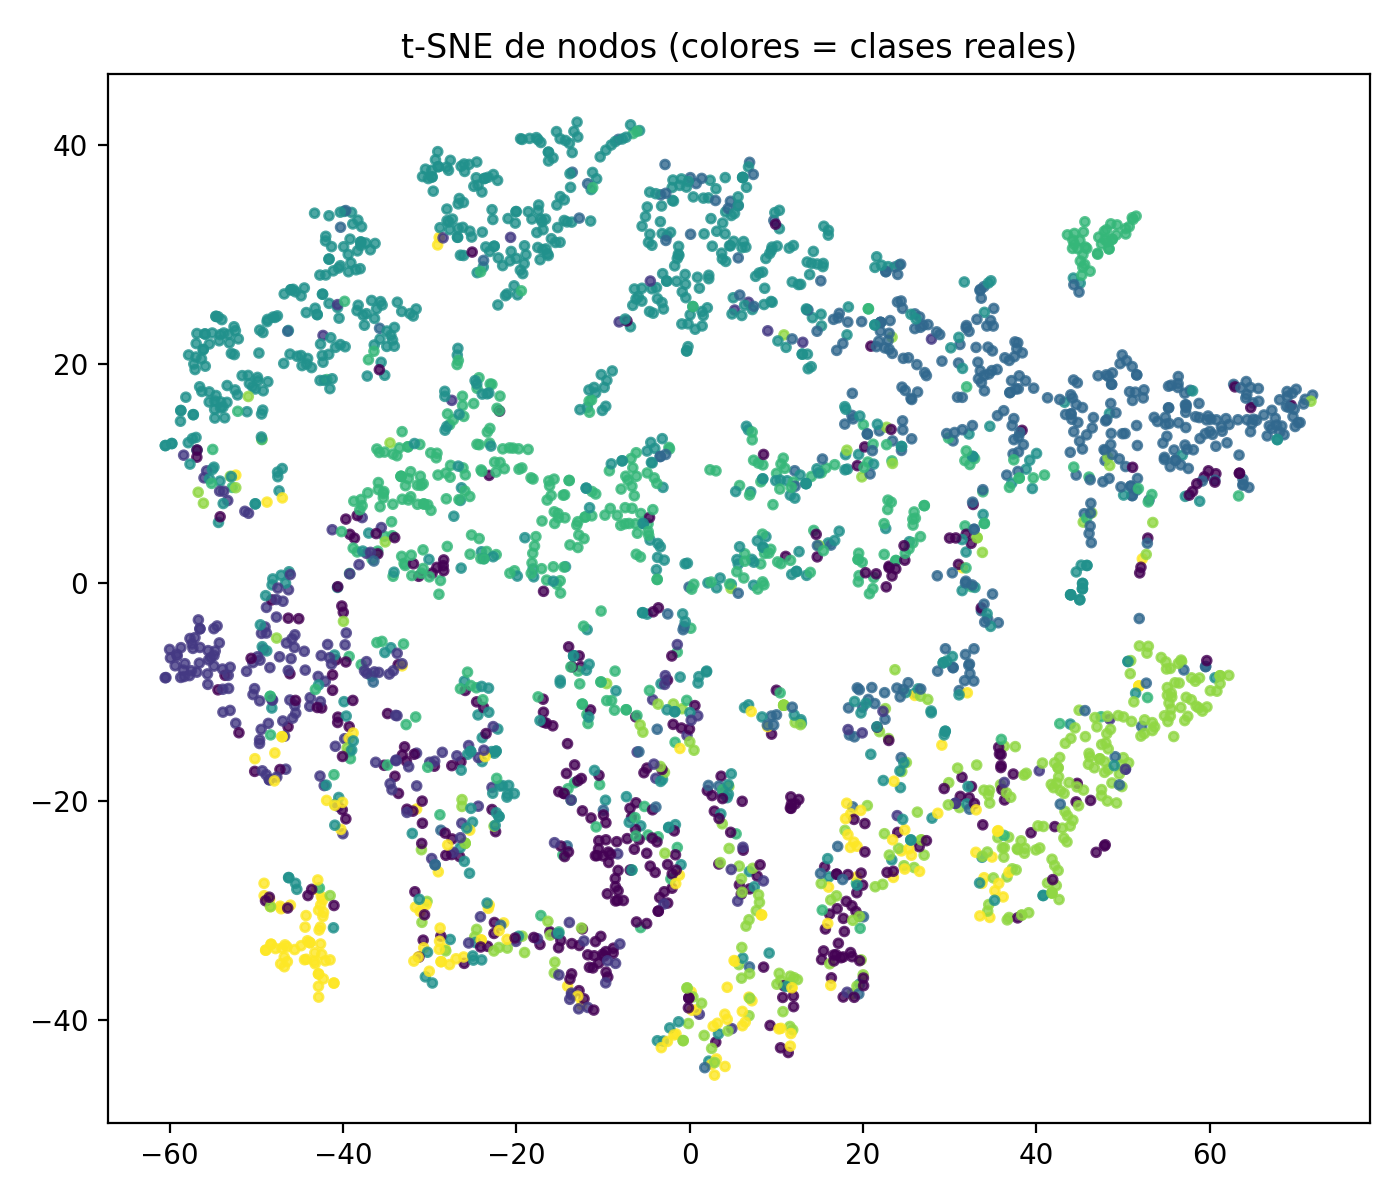

In [11]:
from IPython.display import Image, display

display(Image(filename="tsne_nodes.png", width=600))